In [14]:
initial_path = 'peptide-QML'
initial_path = '..'

In [15]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
sweep = c.Sweep.load(
    initial_path=initial_path,
    day='0926',
    file_name='sweep_6h_er_Aqm-2',
)
sweep.lists.keys()

dict_keys(['idx', 'repetitions', 'block_n_layers', 'embedding_n_layers', 'ansatz', 'model_uuid', 'best_loss_train', 'best_loss_test', 'loss_validation', 'n_parameters', 'time_train'])

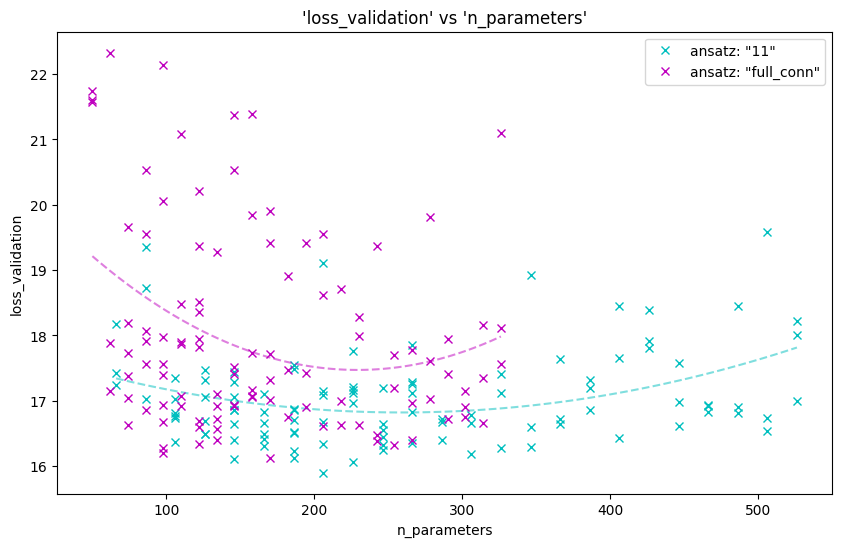

In [17]:
sweep.plot(
    x_key='n_parameters',
    y_key='loss_validation',
    legend_keys=['ansatz'],
    fit_degree=2,
    replace=[("<class 'my_code.quantum_nodes.parts.Ansatz_full_conn'>", 'full_conn'), ("<class 'my_code.quantum_nodes.parts.Ansatz_11'>", '11')],
    fix = [],
    to_string = ['ansatz'],
    colors = [ 'c', 'm', 'y', 'k', 'w'],
)

In [18]:
sweep_point = sweep.get_point_min('loss_validation', fix=[('ansatz', "<class 'my_code.quantum_nodes.parts.Ansatz_11'>")], to_string=['ansatz'])

In [19]:
sweep_point

{'idx': 103,
 'repetitions': 2,
 'block_n_layers': 7,
 'embedding_n_layers': 1,
 'ansatz': my_code.quantum_nodes.parts.Ansatz_11,
 'model_uuid': UUID('a387396b-4809-451c-a2a7-fa7927f4a875'),
 'best_loss_train': 17.21882565389783,
 'best_loss_test': 13.942473858939985,
 'loss_validation': 15.899755195571274,
 'n_parameters': 206,
 'time_train': 917.2647778987885}

In [20]:
# -- QUANTUM BLOCK -- #
n_qubits = 6
quantum_layer = q.circuit(
    n_qubits = n_qubits, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = q.parts.AngleEmbedding,
    embedding_ansatz = sweep_point['ansatz'],
    block_ansatz = sweep_point['ansatz'],
    final_ansatz = sweep_point['ansatz'], 
    measurement = q.parts.Measurement('Z', 'all'),
    embedding_n_layers = sweep_point['embedding_n_layers'],
    different_inputs_per_layer = False,
    block_n_layers = sweep_point['block_n_layers'],
    # wrapper_qlayer = pw.QLayerEmpty,
)

# -- MODEL -- #                    
class Model(m.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=1)
        self.fc2 = m.Reshape()
        self.fc3 = quantum_layer()            
        self.fc4 = m.nn.Linear(n_qubits, 1)

    def forward(self, x):
        for i in [1,2,3,4]:
            x = getattr(self, 'fc{}'.format(i))(x)
        return x

model = Model()
model.set_quantum_layer(quantum_layer)
model.set_name_and_path(None, initial_path)
model.load_results(uuid=sweep_point['model_uuid'])
model.load_state_dict_from_results(state_dict_name="parameters_epoch", rule="best")

Loaded results with uuid a387396b-4809-451c-a2a7-fa7927f4a875.
Loaded best state_dict from results.


In [ ]:
model(m.torch.tensor([0, 1, 2, 3, 4, 5], dtype=m.torch.int))

tensor([-9.7724], grad_fn=<AddBackward0>)

In [39]:
model.get_input_with_low_score(
    layers_to_use = ['fc3', 'fc4'],
    n_iter = 1000,
    optimizer = m.torch.optim.Adam,
    optimizer_options = {'lr': 0.1},
    stop_criterion = 1e-4,
    initialization_seed = 4,
)

(5, 18, 16, 16, 5, 5), score: -18.2578                    

In [42]:
model.save_input_optimization_results()

In [40]:
model.optimized_inputs

[((5, 5, 4, 5, 5, 5), -24.146447206802897),
 ((5, 5, 4, 5, 5, 5), -24.146447206802897),
 ((5, 18, 16, 16, 5, 5), -18.257755150663982),
 ((5, 18, 16, 16, 5, 5), -18.257755150663982),
 ((5, 18, 16, 16, 5, 5), -18.257755150663982),
 ((5, 18, 16, 16, 5, 5), -18.257755150663982),
 ((16, 18, 16, 16, 5, 4), -13.38504707477991),
 ((5, 5, 4, 5, 5, 5), -24.146447206802897),
 ((5, 18, 16, 16, 5, 5), -18.257755150663982)]

In [41]:
model.optimized_inputs_unique

[((16, 18, 16, 16, 5, 4), -13.38504707477991),
 ((5, 18, 16, 16, 5, 5), -18.257755150663982),
 ((5, 5, 4, 5, 5, 5), -24.146447206802897)]